In [2]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import pathlib
from IPython import display
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch import nn, optim
import seaborn as sns
from torchvision import datasets
import torchvision.utils as vutils
from tqdm.auto import tqdm

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)
! nvidia-smi

cuda
Thu Jul  7 18:41:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.65       Driver Version: 511.65       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   49C    P0    36W / 151W |    669MiB /  8192MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+--

# Load Dataset

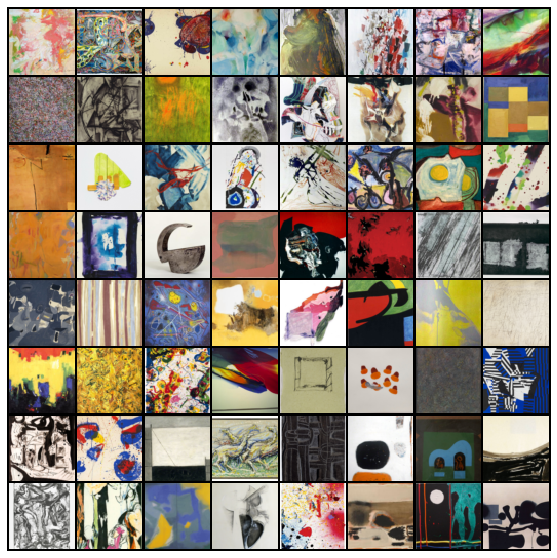

In [3]:
BATCH_SIZE = 64
IMG_SIZE = 64

norm=((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Means, Stds
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(*norm,inplace=True),
])

def unnorm(images, means, stds):
    means = torch.tensor(means).reshape(1,3,1,1)
    stds = torch.tensor(stds).reshape(1,3,1,1)
    return images * stds + means


dataset = datasets.ImageFolder(root="./Abstract_gallery",transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

def show_batch(data_loader):
    for images, labels in data_loader:
        plt.subplots(figsize=(12, 10))
        plt.axis("off")
        raw_images = unnorm(images, *norm)
        plt.imshow(make_grid(raw_images[:BATCH_SIZE], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

show_batch(dataloader)

# DCGAN

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.cnn = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.cnn(x)

generator = Generator()
generator.to(DEVICE)

Generator(
  (cnn): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

discriminator = Discriminator()
discriminator.to(DEVICE)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [ ]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, 100, 1, 1, device=DEVICE)

real_label = 1.
fake_label = 0.

discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
generator_optimizer = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))

In [ ]:
img_list = []
g_losses, d_losses = [], []
total = 0

def plot_loss(G_losses, D_losses):
    plt.figure(figsize=(12, 8))
    plt.plot(G_losses,label="Generator")
    plt.plot(D_losses,label="Discriminator")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

def plot_images(imgs, epoch):
    plt.subplots(figsize=(12, 10))
    plt.axis("off")
    plt.title(f"Epoch {epoch}")
    raw_images = unnorm(imgs, *norm)
    plt.imshow(make_grid(raw_images[:BATCH_SIZE], nrow=8).permute(1, 2, 0).clamp(0,1))
    plt.show()

for epoch in tqdm(range(401)):
    g_loss = 0.0
    d_loss = 0.0

    for i, data in tqdm(enumerate(dataloader, 0), total=len(dataloader)):
        # Train Discriminator
        discriminator.zero_grad()
        # Real
        real_images = data[0].to(DEVICE)
        batch_size = real_images.size(0)
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=DEVICE)
        output = discriminator(real_images).view(-1)
        dl_real = criterion(output, label)
        dl_real.backward()
        # Fake
        noise = torch.randn(batch_size, 100, 1, 1, device=DEVICE)
        fake = generator(noise)
        label.fill_(fake_label)
        output = discriminator(fake.detach()).view(-1)
        dl_fake = criterion(output, label)
        dl_fake.backward()
        dl = dl_real + dl_fake
        discriminator_optimizer.step()

        # Train Generator
        generator.zero_grad()
        label.fill_(real_label)
        output = discriminator(fake).view(-1)
        gl = criterion(output, label)
        gl.backward()
        generator_optimizer.step()

        g_loss += gl.item()
        d_loss += dl.item()
        total += batch_size

    avg_g_loss = g_loss / total
    g_losses.append(avg_g_loss)
    avg_d_loss = d_loss / total
    d_losses.append(avg_d_loss)

    print(f"Epoch: {epoch + 1} - Discriminator_Loss: {avg_d_loss:.6f} - Generator_Loss: {avg_g_loss:.6f}")

    with torch.no_grad():
        fake = generator(fixed_noise).detach().cpu()
    imgs = vutils.make_grid(unnorm(fake, *norm), padding=2, normalize=True)
    img_list.append(imgs)
    if epoch % 100 == 0:
        plot_images(fake, epoch)
        plot_loss(g_losses, d_losses)

# 1 WGAN + More

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
#             nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
generator = Generator()
generator.to(DEVICE)
discriminator = Discriminator()
discriminator.to(DEVICE)

criterion = nn.BCELoss()
fixed_noise = torch.randn(64, 100, 1, 1, device=DEVICE)
real_label = 1.
fake_label = 0.
# discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
# generator_optimizer = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))

discriminator_optimizer = optim.RMSprop(discriminator.parameters(), lr=0.00005, weight_decay=1e-5)
generator_optimizer = optim.RMSprop(generator.parameters(), lr=0.00005)

In [ ]:
img_list = []
g_losses, d_losses = [], []
total = 0

def plot_loss(G_losses, D_losses):
    plt.figure(figsize=(12, 8))
    plt.plot(G_losses,label="Generator")
    plt.plot(D_losses,label="Discriminator")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

def plot_images(imgs, epoch):
    plt.subplots(figsize=(12, 10))
    plt.axis("off")
    plt.title(f"Epoch {epoch}")
    raw_images = unnorm(imgs, *norm)
    plt.imshow(make_grid(raw_images[:BATCH_SIZE], nrow=8).permute(1, 2, 0).clamp(0,1))
    plt.show()

for epoch in tqdm(range(401)):
    g_loss = 0.0
    d_loss = 0.0

    for i, data in tqdm(enumerate(dataloader, 0), total=len(dataloader)):
        for _ in range(1):
            # Train Discriminator
            discriminator.zero_grad()
            # Real
            real_images = data[0].to(DEVICE)
            batch_size = real_images.size(0)
            label = torch.full((batch_size,), real_label, dtype=torch.float, device=DEVICE)
            output_real = discriminator(real_images).view(-1)
            # Fake
            noise = torch.randn(batch_size, 100, 1, 1, device=DEVICE)
            fake = generator(noise)
            label.fill_(fake_label)
            output_fake = discriminator(fake.detach()).view(-1)
            d_wloss = torch.mean(output_fake - output_real)
            d_wloss.backward()
            discriminator_optimizer.step()

            for params in discriminator.parameters():
                params.data.clamp_(-0.01, +0.01)

        # Train Generator
        generator.zero_grad()
        output = discriminator(fake).view(-1)
        g_wloss = -torch.mean(output)
        g_wloss.backward()
        generator_optimizer.step()

        g_loss += g_wloss.item()
        d_loss += d_wloss.item()
        total += batch_size

    avg_g_loss = g_loss / total
    g_losses.append(avg_g_loss)
    avg_d_loss = d_loss / total
    d_losses.append(avg_d_loss)

    print(f"Epoch: {epoch + 1} - Discriminator_Loss: {avg_d_loss:.6f} - Generator_Loss: {avg_g_loss:.6f}")

    with torch.no_grad():
        fake = generator(fixed_noise).detach().cpu()
    imgs = vutils.make_grid(unnorm(fake, *norm), padding=2, normalize=True)
    img_list.append(imgs)
    if epoch % 100 == 0:
        plot_images(fake, epoch)
        plot_loss(g_losses, d_losses)